In [3]:
from predator_prey.model import PredatorPreyModel
from predator_prey.prey import  Prey, PreyUnicicle
from predator_prey.predator import Predator, PredatorUnicicle
from experiment_params import simple_params, unicycle_params
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
# RUN THE EXPERIMENT
params = simple_params
model = PredatorPreyModel(**params)   

In [4]:

while model.generation_counter < 20:
    if model.generation_counter == 150:
        model.mutation_rate = 0.1
        model.mutation_strength = 0.1
        model.mutation_flip_rate = 0.01
    model.step()

Steps: 1001, run: 1, generation: 0
reset_agents
Steps: 2002, run: 2, generation: 0
reset_agents
Steps: 3003, run: 3, generation: 0
new generation
Generation 0 run 3
Steps: 4004, run: 4, generation: 1
reset_agents
Steps: 5005, run: 5, generation: 1
reset_agents
Steps: 6006, run: 6, generation: 1
new generation
Generation 1 run 6
Steps: 7007, run: 7, generation: 2
reset_agents
Steps: 8008, run: 8, generation: 2
reset_agents
Steps: 9009, run: 9, generation: 2
new generation
Generation 2 run 9
Steps: 10010, run: 10, generation: 3
reset_agents
Steps: 11011, run: 11, generation: 3
reset_agents
Steps: 12012, run: 12, generation: 3
new generation
Generation 3 run 12
Steps: 13013, run: 13, generation: 4
reset_agents
Steps: 14014, run: 14, generation: 4
reset_agents
Steps: 15015, run: 15, generation: 4
new generation
Generation 4 run 15
Steps: 16016, run: 16, generation: 5
reset_agents
Steps: 17017, run: 17, generation: 5
reset_agents
Steps: 18018, run: 18, generation: 5
new generation
Generatio

In [11]:
agent_data = model.datacollector.get_agent_vars_dataframe()
model_data = model.datacollector.get_model_vars_dataframe()

MultiIndex([(    1, ...),
            (    1, ...),
            (    1, ...),
            (    1, ...),
            (    1, ...),
            (    1, ...),
            (    1, ...),
            (    1, ...),
            (    1, ...),
            (    1, ...),
            ...
            (60060, ...),
            (60060, ...),
            (60060, ...),
            (60060, ...),
            (60060, ...),
            (60060, ...),
            (60060, ...),
            (60060, ...),
            (60060, ...),
            (60060, ...)],
           names=['Step', 'AgentID'], length=2402400)

In [ ]:
import pickle
import os
experiment_name = 'simple_175_gens_2_message'
experiment_dir = f'experiments/{experiment_name}'
agent_data.index = agent_data.index.set_levels(
    agent_data.index.levels[1].astype(str),
    level=1,
)
print(agent_data)
#agent_data.loc[:,'AgentID'] = agent_data['AgentID'].apply(lambda x: str(x))

os.makedirs(experiment_dir, exist_ok=True)
agent_data.to_hdf(f'{experiment_dir}/agent_data.hdf', key='agent_data', mode='w')
model_data.to_hdf(f'{experiment_dir}/model_data.hdf', key='model_data', mode='w')
pickle.dump(params, open(f'{experiment_dir}/params.pkl', "wb"))


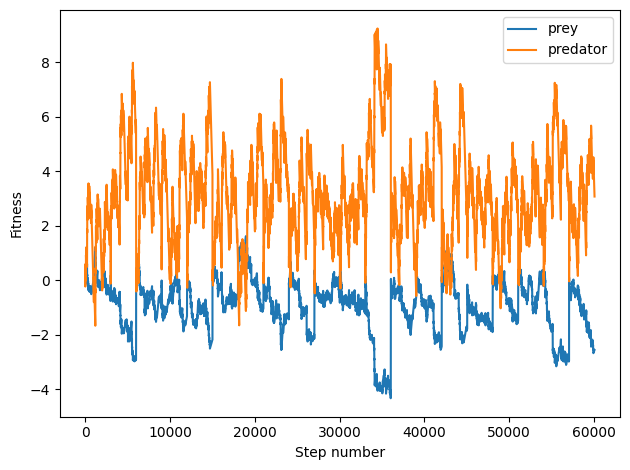

In [6]:
plt.plot(model_data.index, model_data.Avg_prey_fitness, label='prey')
plt.plot(model_data.index, model_data.Avg_predator_fitness, label='predator')
plt.legend()
plt.xlabel('Step number')
plt.ylabel('Fitness')
plt.tight_layout()

In [ ]:
import ast
import pandas as pd
import plotly.express as px

agent_data = model.datacollector.get_agent_vars_dataframe()
model_data = model.datacollector.get_model_vars_dataframe()
# VISUALIZE RESULTS

species_colors = {'predator': 'tomato',
                  'prey':'lightskyblue' }

for generation in agent_data['Generation'].unique()[-3:-1]:  # Last 2 generations
    # Reset index to flatten the DataFrame
    generation_data = agent_data[agent_data['Generation'] == generation]
    generation_data = generation_data[generation_data['Run'] == 1]
    agent_data_reset = generation_data.reset_index()

    # Parse position data and create 'X' and 'Y' columns
    def parse_pos(pos):
        if isinstance(pos, str):
            pos = ast.literal_eval(pos)
        return pos
    
    def parse_message(m):
        return ''.join([str(val) for val in m])

    agent_data_reset.loc[:, 'Pos'] = agent_data_reset['Pos'].apply(parse_pos)
    agent_data_reset.loc[:, 'X'] = agent_data_reset['Pos'].apply(lambda pos: pos[0])
    agent_data_reset.loc[:, 'Y'] = agent_data_reset['Pos'].apply(lambda pos: pos[1])
    agent_data_reset.loc[:, 'message_parsed'] = agent_data_reset['Message'].apply(parse_message)
    # Filter out dead agents if necessary
    agent_data_alive = agent_data_reset[agent_data_reset['Alive'] == True].copy()
    agent_data_alive.loc[:,'agentID_str'] = agent_data_alive['AgentID'].apply(lambda x: str(x))

    # Create offset data
    dx, dy = 0.5, 0.5  # Define your offsets
    agent_data_offset = agent_data_alive.copy()
    agent_data_offset['X'] += dx
    agent_data_offset['Y'] += dy
    agent_data_offset['Set'] = 'Message'
    agent_data_offset['ColorAttribute'] = agent_data_offset['message_parsed']  # Use the column you want to color by
    # Original data
    agent_data_alive['Set'] = 'Original'
    agent_data_alive['ColorAttribute'] = agent_data_alive['Species']

    # Combine the data
    combined_data = pd.concat([agent_data_alive, agent_data_offset])

    # Create the interactive scatter plot
    fig = px.scatter(
        combined_data,
        x='X',
        y='Y',
        animation_frame='Step',
        animation_group='agentID_str',
        color='ColorAttribute',
        symbol='Set',
        color_discrete_map=species_colors,
        hover_name='agentID_str',
        hover_data={'Fitness': True,
                    'Heading': True,
                    'Speed': True},
        range_x=[combined_data['X'].min() - 1, combined_data['X'].max() + 1],
        range_y=[combined_data['Y'].min() - 1, combined_data['Y'].max() + 1],
        labels={'X': 'X Position', 'Y': 'Y Position'},
        title=f'Generation {generation}'
    )

    # Customize the layout
    fig.update_layout(
        width=800,
        height=600,
        xaxis=dict(scaleanchor="y", scaleratio=1),
        yaxis=dict(scaleanchor="x", scaleratio=1),
        legend_title_text='Species'
    )

    animation_speed = 20  # Duration of each frame in milliseconds (smaller value means faster animation)

    if 'updatemenus' in fig.layout:
        for button in fig.layout.updatemenus[0].buttons:
            if button.method == 'animate':
                button.args[1]['frame']['duration'] = animation_speed
                button.args[1]['transition']['duration'] = 0  # Instant transition
                # Optional: Enable looping
                # button.args[1]['loop'] = True

    # Modify the existing sliders
    if 'sliders' in fig.layout:
        for slider in fig.layout.sliders:
            for step in slider['steps']:
                if 'args' in step and len(step['args']) > 1:
                    step['args'][1]['frame']['duration'] = animation_speed
                    step['args'][1]['transition']['duration'] = 0


    fig.show()
    #fig.write_html(f'generation_{generation}.html')

In [22]:
from scipy.spatial import cKDTree
import numpy as np
import pandas as pd

# Initialize list for mean NNDs
generations = agent_data['Generation'].unique()
def get_mean_nnd(data):
    mean_nnd_over_time = []
    time_steps = data.index.get_level_values('Step').unique()
# Loop over time steps
    for step in time_steps:
        # Extract positions
        agent_positions_step = data.xs(step, level='Step').copy()
        positions = agent_positions_step['Pos'].tolist()
        positions_array = np.array(positions)
        
        # Calculate NND
        if len(positions_array) >= 2:
            tree = cKDTree(positions_array)
            distances, indices = tree.query(positions_array, k=2)
            nearest_distances = distances[:, 1]
            mean_nnd = np.mean(nearest_distances)
        else:
            nearest_distances = np.array([])
            mean_nnd = np.nan
        mean_nnd_over_time.append(mean_nnd)
    return np.mean(mean_nnd_over_time)


def get_avg_remaining_prey(data):
    runs = data['Run'].unique()
    alive_prey_per_run = []
    for run in runs: 
        run_data = data[data['Run'] == run]
        max_step = run_data.index.get_level_values(0).max()
        last_step = run_data.xs(max_step, 0)
        last_step_prey = last_step[last_step['Species'] == 'prey']
        n_alive_prey = np.sum(last_step_prey['Alive'])
        alive_prey_per_run.append(n_alive_prey)
    return np.mean(alive_prey_per_run)

prey_nnd = []
predator_nnd = []
average_alive_prey = []
for generation in generations:
    generation_data = agent_data[agent_data['Generation'] == generation]
    prey_data = generation_data[generation_data['Species'] == 'prey']
    predator_data = generation_data[generation_data['Species'] == 'predator']
    prey_nnd.append(get_mean_nnd(prey_data))
    predator_nnd.append(get_mean_nnd(predator_data))
    average_alive_prey.append(get_avg_remaining_prey(generation_data))


generation_data_df = pd.DataFrame(data={
  'generation': generations,
  'predator_nnd': predator_nnd,
  'prey_nnd': prey_nnd,
  'predator_nnd': predator_nnd
})

generation_data_df.to_csv(f'{experiment_dir}/generation_metrics.csv')

NameError: name 'experiment_dir' is not defined

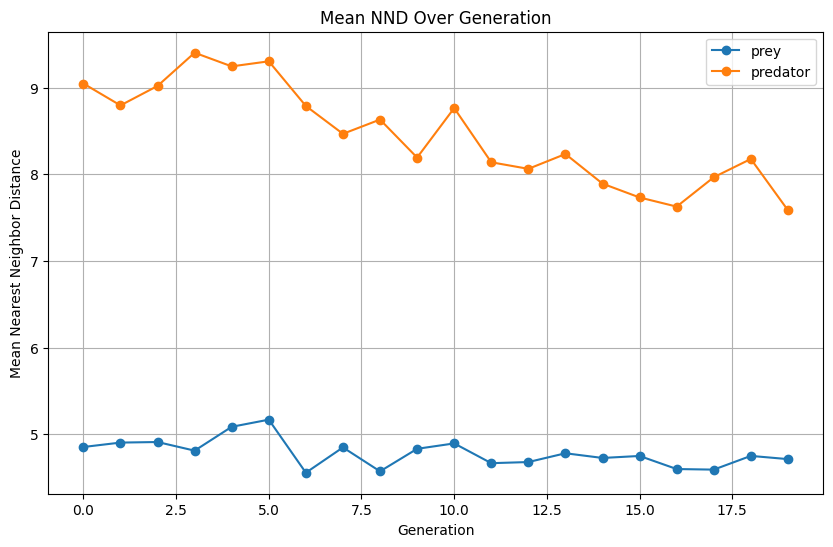

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(prey_nnd, marker='o', label='prey')
plt.plot(predator_nnd, marker='o', label='predator')
plt.xlabel('Generation')
plt.ylabel('Mean Nearest Neighbor Distance')
plt.title('Mean NND Over Generation')
plt.legend()
plt.grid(True)
plt.show()

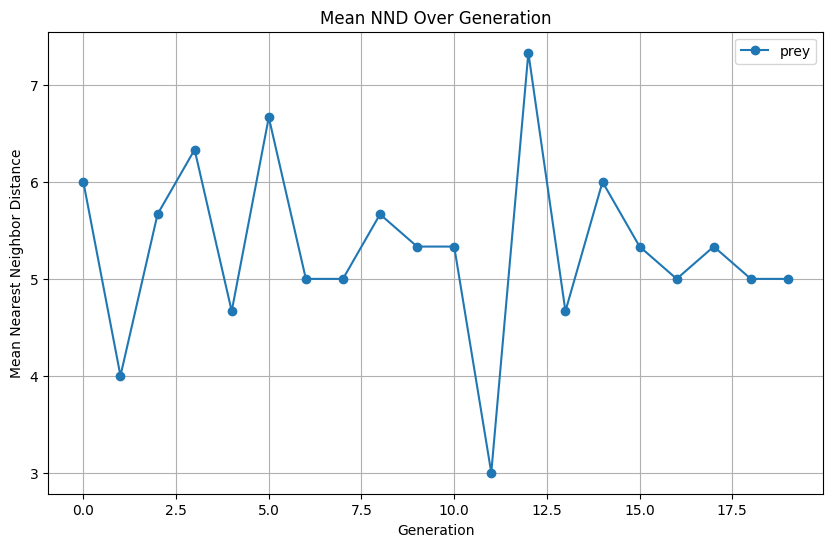

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(average_alive_prey, marker='o', label='prey')
plt.xlabel('Generation')
plt.ylabel('Mean Nearest Neighbor Distance')
plt.title('Mean NND Over Generation')
plt.legend()
plt.grid(True)
plt.show()